In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
import lightgbm as lgb
from sklearn.impute import SimpleImputer
import gc
from joblib import Parallel, delayed
from pathlib import Path
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time
import os
import pickle

In [2]:
SEMILLAS = [550007, 550019, 550031, 550033, 550047]

mes_train = 202103, 202102, 202101
mes_test = 202104
mes_kaggle = 202106
ganancia_acierto = 780000
costo_estimulo = 20000
# =====================

In [ ]:
#Que archivos son? esos meses seleccionados SIN SLOPE
#df_train.write_csv("data/df_train_01_02_03.csv")
#df_test.write_csv("data/df_test_04.csv")   

In [3]:
df_train = pd.read_csv("data/df_train_01_02_03.csv")
df_test = pd.read_csv("data/df_test_04.csv")

In [10]:
# Liberar memoria antes de empezar
gc.collect()

1515

In [4]:
df_kaggle = pd.read_csv("data/df_kaggle.csv")

In [4]:
#tiene mi df_train la columna "clase_ternaria"?
print("clase_ternaria" in df_train.columns)

True


In [5]:
df_train['clase_peso'] = 1.0

df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

#Optimización con LightGBM

In [6]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Separar X e y
X = df_train.drop(["clase_ternaria", "clase_peso"], axis=1)  # ✅ Sacamos también clase_peso
y = df_train["clase_ternaria"]
pesos = df_train["clase_peso"]  # ✅ Guardamos los pesos

# Binarizar y
y_binaria = (y != "CONTINUA").astype(int)

# Split 70/30 (ahora incluimos los pesos)
X_train, X_val, y_train, y_val, pesos_train, pesos_val = train_test_split(
    X, y_binaria, pesos,  # ✅ Separamos X, y Y pesos
    train_size=0.7,
    random_state=42,
    stratify=y_binaria
)

print("Train:", X_train.shape, y_train.shape, pesos_train.shape)
print("Validation:", X_val.shape, y_val.shape, pesos_val.shape)

# Ahora en el Dataset:
train_data = lgb.Dataset(X_train,
                          label=y_train,
                          weight=pesos_train  # ✅ Usamos los pesos del train
                          )

Train: (340753, 802) (340753,) (340753,)
Validation: (146038, 802) (146038,) (146038,)


In [4]:
def ganancia_prob(y_pred, data):
  weight = data.get_weight()
  ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
  ganancia = ganancia[np.argsort(y_pred)[::-1]]
  ganancia = np.cumsum(ganancia)  # ✅ Bien
  return 'gan_eval', np.max(ganancia), True
  


In [13]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.1) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 300, 1000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': SEMILLAS[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train, # eligir la clase
                              weight=pesos_train
                              )
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=ganancia_prob,
        stratified=True,
        nfold=3,
        seed=SEMILLAS[0],
        callbacks=[
                lgb.early_stopping(stopping_rounds=int(50 + 5/learning_rate), verbose=False),
                lgb.log_evaluation(period=200),
                ]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 3
# Al final de objective()
gc.collect()

#guardar el archivo en mi carpeta data
storage_name = "sqlite:///data/optimization_lgbm.db"

study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-10-09 16:41:37,005] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [14]:
study.optimize(objective, n_trials=30) # subir subir

[I 2025-10-09 16:43:25,676] Trial 15 finished with value: 824520000.0 and parameters: {'num_leaves': 13, 'learning_rate': 0.032922995753811045, 'min_data_in_leaf': 964, 'feature_fraction': 0.2632501067072054, 'bagging_fraction': 0.28635017212034686}. Best is trial 15 with value: 824520000.0.
[I 2025-10-09 16:45:32,227] Trial 16 finished with value: 1027440000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.07720399027065392, 'min_data_in_leaf': 658, 'feature_fraction': 0.39718138159387195, 'bagging_fraction': 0.3601895736680899}. Best is trial 16 with value: 1027440000.0.
[I 2025-10-09 16:47:35,837] Trial 17 finished with value: 791800000.0 and parameters: {'num_leaves': 49, 'learning_rate': 0.007962520110203843, 'min_data_in_leaf': 895, 'feature_fraction': 0.4706483103904118, 'bagging_fraction': 0.4298206201719591}. Best is trial 16 with value: 1027440000.0.
[I 2025-10-09 16:49:25,185] Trial 18 finished with value: 834300000.0 and parameters: {'num_leaves': 12, 'learning_rate

In [18]:
import json
# Obtener los mejores 10 trials
best_trials = study.trials_dataframe().sort_values('value', ascending=False).head(10)

# Opción 1: Guardar como lista de diccionarios (más completo)
mejores_params = []
for i, trial in enumerate(study.best_trials[:10] if len(study.best_trials) >= 10 else study.best_trials):
    mejores_params.append({
        'rank': i + 1,
        'trial_number': trial.number,
        'value': trial.value,
        'params': trial.params,
        'best_iter': trial.user_attrs.get('best_iter', None)
    })

# Guardar en JSON
with open('data/mejores_hiperparametros.json', 'w', encoding='utf-8') as f:
    json.dump(mejores_params, f, indent=4, ensure_ascii=False)



In [4]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import json
import matplotlib.pyplot as plt
import gc

# ============================================================
# PREPARAR DATOS DE TRAIN - OPTIMIZADO PARA MEMORIA
# ============================================================

print("="*60)
print("PREPARANDO DATOS TRAIN")
print("="*60)

# 1. Crear pesos en df_train
print("Creando pesos...")
df_train['clase_peso'] = 1.0
df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

# 2. Convertir a numpy inmediatamente (más eficiente en memoria)
print("Convirtiendo a numpy (float32)...")
X_train = df_train.drop(["clase_ternaria", "clase_peso"], axis=1).to_numpy().astype('float32')
y_train = df_train["clase_ternaria"].to_numpy()
pesos_train = df_train["clase_peso"].to_numpy().astype('float32')

# Binarizar
y_train_binaria = (y_train != "CONTINUA").astype('int8')

print(f"X_train: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train_binaria: {y_train_binaria.shape}, dtype: {y_train_binaria.dtype}")
print(f"Clase positiva: {y_train_binaria.sum():,}")
print(f"Clase negativa: {(y_train_binaria == 0).sum():,}")

# Liberar df_train de la memoria
print("Liberando df_train de memoria...")
del df_train, y_train
gc.collect()

print("✅ Datos TRAIN preparados y df_train liberado")

# ============================================================
# PREPARAR DATOS DE TEST
# ============================================================

print("\n" + "="*60)
print("PREPARANDO DATOS TEST")
print("="*60)

X_test = df_test.drop("clase_ternaria", axis=1).to_numpy().astype('float32')
y_test = df_test["clase_ternaria"].to_numpy()

print(f"X_test: {X_test.shape}, dtype: {X_test.dtype}")
print(f"y_test: {y_test.shape}")

# Liberar df_test si no lo necesitás más
print("Liberando df_test de memoria...")
del df_test
gc.collect()

print("✅ Datos TEST preparados")

# ============================================================
# DEFINIR MÉTRICA PERSONALIZADA DE GANANCIA
# ============================================================

ganancia_acierto = 780000
costo_estimulo = 20000

def ganancia_lgb(y_pred, data):
    """Métrica personalizada de ganancia para LightGBM."""
    weight = data.get_weight()
    
    # Calcular ganancia para cada predicción
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - costo_estimulo
    
    # Ordenar por predicción descendente
    indices = np.argsort(-y_pred)
    ganancia_ordenada = ganancia[indices]
    
    # Calcular ganancia acumulada máxima
    ganancia_acum = np.cumsum(ganancia_ordenada)
    max_ganancia = np.max(ganancia_acum)
    
    return 'ganancia', max_ganancia, True

# ============================================================
# ENTRENAR CON TRAIN Y EVALUAR EN TEST
# ============================================================

def entrenar_modelo_test(mejores_params_path='data/mejores_hiperparametros.json'):
    """Entrena el modelo con df_train usando la métrica de ganancia."""
    
    print(f"\nCargando hiperparámetros desde {mejores_params_path}...")
    with open(mejores_params_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    config = data[0] if isinstance(data, list) else data
    
    print(f"Trial {config['trial_number']}")
    print(f"Ganancia esperada en CV: ${config['value']:,.0f}")
    
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': config['params']['num_leaves'],
        'learning_rate': config['params']['learning_rate'],
        'min_data_in_leaf': config['params']['min_data_in_leaf'],
        'feature_fraction': config['params']['feature_fraction'],
        'bagging_fraction': config['params']['bagging_fraction'],
        'seed': SEMILLAS[0],
        'verbose': 1
    }
    
    print("\nParámetros del modelo:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Crear dataset (free_raw_data=True para ahorrar memoria)
    print(f"\nCreando dataset con X_train: {X_train.shape}")
    train_data = lgb.Dataset(X_train,
                             label=y_train_binaria,
                             weight=pesos_train,
                             free_raw_data=False)  # Cambiar a True si sigue fallando
    
    # Entrenar modelo
    print(f"Entrenando modelo con {config['best_iter']} iteraciones...")
    model = lgb.train(
        params,
        train_data,
        num_boost_round=config['best_iter'],
        feval=ganancia_lgb,
        callbacks=[lgb.log_evaluation(period=50)]
    )
    
    print("✅ Modelo entrenado exitosamente")
    
    # Liberar train_data
    del train_data
    gc.collect()
    
    return model, config


def calcular_ganancia_test(model, X_test, y_test):
    """Calcula la ganancia en TEST y encuentra el umbral óptimo."""
    
    print("\n" + "="*60)
    print("EVALUANDO EN TEST")
    print("="*60)
    
    print(f"Generando predicciones en X_test: {X_test.shape}")
    y_test_pred_prob = model.predict(X_test)
    
    indices_ordenados = np.argsort(-y_test_pred_prob)
    y_test_sorted = y_test[indices_ordenados]
    
    print("Calculando ganancia acumulada...")
    ganancia_cum = np.cumsum([
        (ganancia_acierto if y == "BAJA+2" else -costo_estimulo)
        for y in y_test_sorted
    ])
    
    max_ganancia_idx = np.argmax(ganancia_cum)
    max_ganancia = ganancia_cum[max_ganancia_idx]
    n_envios_optimo = max_ganancia_idx + 1
    threshold_optimo = y_test_pred_prob[indices_ordenados[max_ganancia_idx]]
    
    print(f"\n📊 RESULTADOS EN TEST:")
    print(f"  Ganancia máxima: ${max_ganancia:,.0f}")
    print(f"  N° de envíos óptimo: {n_envios_optimo:,}")
    print(f"  Threshold óptimo: {threshold_optimo:.6f}")
    print(f"  % de la base: {n_envios_optimo / len(y_test) * 100:.2f}%")
    
    print("\n📈 GANANCIA POR CANTIDAD DE ENVÍOS:")
    for percentil in [0.01, 0.025, 0.05, 0.10]:
        n = int(len(y_test) * percentil)
        ganancia_n = ganancia_cum[n-1] if n > 0 else 0
        print(f"  Top {percentil*100:.1f}% ({n:,} envíos): ${ganancia_n:,.0f}")
    
    n_baja2_total = (y_test == "BAJA+2").sum()
    n_baja2_capturados = (y_test_sorted[:n_envios_optimo] == "BAJA+2").sum()
    print(f"\n🎯 CAPTURA DE BAJA+2:")
    print(f"  Total BAJA+2: {n_baja2_total:,}")
    print(f"  Capturados: {n_baja2_capturados:,}")
    print(f"  Tasa: {n_baja2_capturados / n_baja2_total * 100:.2f}%")
    
    return {
        'ganancia_maxima': max_ganancia,
        'n_envios_optimo': n_envios_optimo,
        'threshold_optimo': threshold_optimo,
        'ganancia_acumulada': ganancia_cum,
        'probabilidades_ordenadas': y_test_pred_prob[indices_ordenados],
        'y_test_sorted': y_test_sorted,
        'n_baja2_capturados': n_baja2_capturados,
        'n_baja2_total': n_baja2_total
    }


# ============================================================
# FLUJO COMPLETO
# ============================================================

print("\n" + "="*60)
print("ENTRENAMIENTO CON TRAIN")
print("="*60)

model_test, config = entrenar_modelo_test('data/mejores_hiperparametros.json')

resultados_test = calcular_ganancia_test(model_test, X_test, y_test)

with open('data/resultados_test.json', 'w') as f:
    json.dump({
        'ganancia_maxima': float(resultados_test['ganancia_maxima']),
        'n_envios_optimo': int(resultados_test['n_envios_optimo']),
        'threshold_optimo': float(resultados_test['threshold_optimo']),
        'n_baja2_capturados': int(resultados_test['n_baja2_capturados']),
        'n_baja2_total': int(resultados_test['n_baja2_total'])
    }, f, indent=4)

print("\n✅ Resultados guardados")

model_test.save_model('data/modelo_train_test.txt')
print("✅ Modelo guardado")

PREPARANDO DATOS TRAIN
Creando pesos...
Convirtiendo a numpy (float32)...
X_train: (486791, 802), dtype: float32
y_train_binaria: (486791,), dtype: int8
Clase positiva: 5,284
Clase negativa: 481,507
Liberando df_train de memoria...
✅ Datos TRAIN preparados y df_train liberado

PREPARANDO DATOS TEST
X_test: (163418, 802), dtype: float32
y_test: (163418,)
Liberando df_test de memoria...
✅ Datos TEST preparados

ENTRENAMIENTO CON TRAIN

Cargando hiperparámetros desde data/mejores_hiperparametros.json...
Trial 39
Ganancia esperada en CV: $1,058,480,000

Parámetros del modelo:
  objective: binary
  metric: custom
  boosting_type: gbdt
  first_metric_only: True
  boost_from_average: True
  feature_pre_filter: False
  max_bin: 31
  num_leaves: 91
  learning_rate: 0.09904281706673441
  min_data_in_leaf: 370
  feature_fraction: 0.9029799021041279
  bagging_fraction: 0.5198907300236562
  seed: 550007
  verbose: 1

Creando dataset con X_train: (486791, 802)
Entrenando modelo con 100 iteraciones..

Mejores hip:
n_estimators e/ 250 y 350
max_depht e/ 20 y 25
min_sample_split e/ 50 y 90
min_sample_leaf e/30 y 50
criterion: entropy
max_leaf_nodes e45 y cuanto?? todas en 50

In [22]:
#lista de feature importances y porcentajes 

importances = model_opt.feature_importances_
feature_names = X.columns   
# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
print(importance_df.sort_values(by='Importance', ascending=False).head(60))

                                  Feature  Importance
107                          ctrx_quarter    0.048973
365                      ctrx_quarter_max    0.045724
364                      ctrx_quarter_min    0.034558
252                      cpayroll_trx_min    0.033572
18                           mcaja_ahorro    0.032253
173                   mpasivos_margen_max    0.032014
52                               mpayroll    0.031691
254                          mpayroll_min    0.028546
11                        mpasivos_margen    0.027750
51                           cpayroll_trx    0.027207
253                      cpayroll_trx_max    0.019877
28                  mtarjeta_visa_consumo    0.019612
186                      mcaja_ahorro_min    0.018973
172                   mpasivos_margen_min    0.018673
187                      mcaja_ahorro_max    0.017311
255                          mpayroll_max    0.017055
195                    mcuentas_saldo_max    0.015716
22                         m

## Canaritos

In [ ]:
#Canaritos rf en mes train
#uso esta semilla para los canaritos
# np.random.seed(102191)

# # Agregar 200 columnas aleatorias uniformes entre 0 y 1
# for i in range(1, 201):
#     df_filtrado = df_filtrado.with_columns(
#         pl.Series(f"canarito_{i}", np.random.rand(df_filtrado.height))
#     )

# df_filtrado.shape

(326527, 955)

In [ ]:
# # Filtrar train
# X = df_filtrado.filter(pl.col("foto_mes") == mes_train)
# y = X["clase_ternaria"]
# X = X.drop("clase_ternaria")

# # Filtrar validación/futuro
# X_futuro = df_filtrado.filter(pl.col("foto_mes") == mes_test)
# y_futuro = X_futuro["clase_ternaria"]
# X_futuro = X_futuro.drop("clase_ternaria")

In [ ]:
# #Parametros optimizados
# param_opt = {'criterion': 'entropy',
#              'n_estimators': 100,
#              'max_depth': 20,
#              'min_samples_split': 80,
#              'min_samples_leaf': 40,
#              'max_leaf_nodes': 13}

# model_opt = RandomForestClassifier(random_state=SEMILLAS[0], **param_opt)

# model_opt.fit(X, y)
# y_pred_opt = model_opt.predict_proba(X_futuro)
# print(f"Ganancia de modelo Opt: {ganancia_prob(y_pred_opt, y_futuro)}")

Ganancia de modelo Opt: 294620000.0


In [ ]:
# #lista de feature importances y porcentajes 

# importances = model_opt.feature_importances_
# feature_names = X.columns   
# # Crear un DataFrame para visualizar las importancias
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# })
# print(importance_df.sort_values(by='Importance', ascending=False).head(160))

                              Feature  Importance
187                  mcaja_ahorro_max    0.049571
107                      ctrx_quarter    0.041316
364                  ctrx_quarter_min    0.036957
18                       mcaja_ahorro    0.032666
52                           mpayroll    0.031583
..                                ...         ...
516   mprestamos_personales_diff_prev    0.000556
465          mrentabilidad_diff_prev2    0.000524
732     Visa_madelantopesos_diff_prev    0.000523
507  mtarjeta_visa_consumo_diff_prev2    0.000517
715            Visa_status_diff_prev2    0.000507

[160 rows x 2 columns]


In [ ]:
# # Tomamos las 160 variables más importantes
# top_features = importance_df.head(400)

# # Contar cuántas tienen el prefijo 'canarito'
# canarito_count = top_features['Feature'].str.startswith("canarito").sum()

# print(f"Cantidad de variables 'canarito' en el Top 160: {canarito_count}")


Cantidad de variables 'canarito' en el Top 160: 13


In [ ]:
# # Asegurar que está ordenado por importancia descendente
# importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# # Agregar columna con la posición
# importance_df["Rank"] = importance_df.index + 1

# # Filtrar solo las variables 'canarito'
# canaritos = importance_df[importance_df["Feature"].str.startswith("canarito")]

# # Calcular posición media
# pos_media_canaritos = canaritos["Rank"].mean()

# print(f"Posición media de los canaritos: {pos_media_canaritos:.2f}")


Posición media de los canaritos: 816.92


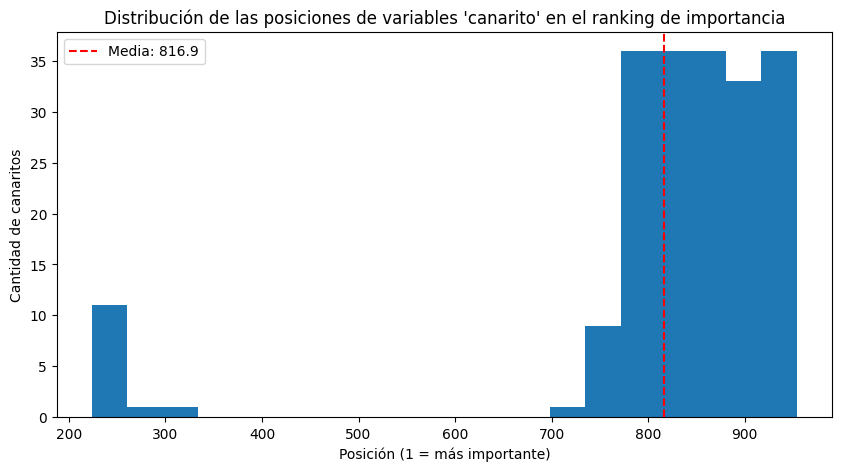

Posición media de las variables 'canarito': 816.9


In [ ]:

# # Gráfico
# plt.figure(figsize=(10, 5))
# plt.hist(canaritos["Rank"], bins=20)
# plt.axvline(pos_media_canaritos, color='red', linestyle='--', label=f"Media: {pos_media_canaritos:.1f}")
# plt.title("Distribución de las posiciones de variables 'canarito' en el ranking de importancia")
# plt.xlabel("Posición (1 = más importante)")
# plt.ylabel("Cantidad de canaritos")
# plt.legend()
# plt.show()

# print(f"Posición media de las variables 'canarito': {pos_media_canaritos:.1f}")

#Ganancia modelo clase 211 MARS sin nada
Ganancia modelo optimizaod acá, 331 mars

## Entrenar Modelos


In [6]:

import json 
# ============================================================
# CARGAR MODELO GUARDADO
# ============================================================

print("Cargando modelo guardado...")
model_test = lgb.Booster(model_file='data/modelo_train_test.txt')
print("✅ Modelo cargado exitosamente")

# ============================================================
# PREDECIR EN KAGGLE
# ============================================================

print("\n" + "="*60)
print("PREDICCIONES PARA KAGGLE")
print("="*60)

# Cargar el número óptimo de envíos
print("Cargando número óptimo de envíos...")
with open('data/resultados_test.json', 'r') as f:
    resultados_test = json.load(f)

n_envios_optimo = resultados_test['n_envios_optimo']
print(f"Número óptimo de envíos: {n_envios_optimo:,}")

# Preparar datos de Kaggle
print("\nPreparando datos de Kaggle...")
X_kaggle = df_kaggle.drop("clase_ternaria", axis=1).to_numpy().astype('float32')
clientes_kaggle = df_kaggle["numero_de_cliente"].to_numpy()

print(f"Datos de Kaggle: {X_kaggle.shape}")

# Predicciones probabilísticas
print("Generando predicciones...")
y_pred_prob = model_test.predict(X_kaggle)

# Seleccionar top N clientes
print(f"Seleccionando top {n_envios_optimo:,} clientes...")
indices_top = np.argsort(-y_pred_prob)[:n_envios_optimo]

# Crear predicción binaria
y_pred_bin = np.zeros(len(y_pred_prob), dtype=int)
y_pred_bin[indices_top] = 1

# Crear submission
submission = pd.DataFrame({
    "numero_de_cliente": clientes_kaggle,
    "Predicted": y_pred_bin
})


Cargando modelo guardado...
✅ Modelo cargado exitosamente

PREDICCIONES PARA KAGGLE
Cargando número óptimo de envíos...
Número óptimo de envíos: 11,403

Preparando datos de Kaggle...
Datos de Kaggle: (164313, 802)
Generando predicciones...
Seleccionando top 11,403 clientes...


In [7]:

# Guardar
submission.to_csv("data/predicciones_kaggle.csv", index=False)

print(f"\n✅ Archivo guardado: 'data/predicciones_kaggle.csv'")
print(f"Total registros: {len(submission):,}")
print(f"Predicciones positivas (1): {y_pred_bin.sum():,}")
print(f"Predicciones negativas (0): {(y_pred_bin == 0).sum():,}")

print("\n📄 Primeras filas:")
print(submission.head())


✅ Archivo guardado: 'data/predicciones_kaggle.csv'
Total registros: 164,313
Predicciones positivas (1): 11,403
Predicciones negativas (0): 152,910

📄 Primeras filas:
   numero_de_cliente  Predicted
0          433987585          0
1          434200463          0
2          434285203          0
3          434436672          0
4          434468833          0


In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Separar X e y

# 1. Definir X: Eliminar la columna 'clase_ternaria' especificando axis=1
X_train = df_train.drop("clase_ternaria", axis=1)

# 2. Definir y: Seleccionar la columna 'clase_ternaria'
y_train = df_train["clase_ternaria"]

# 3. Validación 
X_val = df_test.drop("clase_ternaria", axis=1)
y_val = df_test["clase_ternaria"]


print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)



Train: (163109, 754) (163109,)
Validation: (163418, 754) (163418,)


In [30]:
# -------------------
# Crear LightGBM Dataset
# -------------------

# Convertir y_train a binario: 1 si es BAJA+2, 0 si es CONTINUA
y_train_binaria = ((y_train == "BAJA+2")).astype(int)
y_val_binaria = ((y_val == "BAJA+2")).astype(int)

# Crear pesos: dar más peso a las clases positivas (BAJA+2)
# Opción 1: Peso fijo (ej: 60 veces más peso a las bajas)
w_train = y_train_binaria * 1.00002 + (1 - y_train_binaria) * 1.0
w_val = y_val_binaria * 1.00002 + (1 - y_val_binaria) * 1.0 

# Crear el Dataset de LightGBM
train_data = lgb.Dataset(X_train,
                         label=y_train_binaria,
                         weight=w_train,
                         params={'max_bin': 31} )

val_data = lgb.Dataset(X_val,
                       label=y_val_binaria,
                       weight= w_val,
                       reference=train_data, 
                       params={'max_bin': 31})

In [31]:
import numpy as np
# Estas variables deben ser accesibles globalmente o pasadas como argumentos
# ganancia_acierto = 780000 
# costo_estimulo = 20000

def lgb_gan_eval(y_pred, data):
    """
    Función de evaluación personalizada para LightGBM que calcula la ganancia máxima acumulada.
    
    Esta función asume la siguiente lógica de negocio basada en el peso (weight):
    - weight == 1.00002 : BAJA+2 (Ganancia alta, $780,000)
    - weight < 1.00002 : CONTINUA o BAJA+1 (Costo, -$20,000)
    
    :param y_pred: Puntuaciones sin procesar (log-odds) del modelo.
    :param data: Objeto lgb.Dataset que contiene las etiquetas y los pesos.
    :return: Tupla ('gan_eval', valor_ganancia_max, True)
    """
    
    # 1. Obtener los pesos (w_train) del Dataset
    weight = data.get_weight()

    # 2. Calcular la ganancia/pérdida potencial para CADA FILA (si se contactara):
    #    - Si es BAJA+2 (weight == 1.00002): Ganancia = 780000
    #    - Si NO es BAJA+2 (weight < 1.00002): Ganancia = 0
    #    Luego, RESTAMOS el costo del estímulo (-20000) si NO es BAJA+2, porque
    #    asumimos que la pérdida de -20000 aplica a todos los casos NO BAJA+2
    #    que el modelo prediga incorrectamente.

    # Lógica simplificada del archivo:
    # Acierto: Si es BAJA+2 (peso 1.00002), obtiene 780000.
    ganancia_acierto_real = np.where(weight == 1.00002, ganancia_acierto, 0) 
    
    # Costo: Si NO es BAJA+2 (peso 1.00001 o 1.0), tiene un costo de 20000.
    # Nota: Este enfoque asume que el estímulo SIEMPRE se aplica si la probabilidad es alta
    costo_estimulo_real = np.where(weight < 1.00002, costo_estimulo, 0)
    
    # La ganancia es: (Acierto si es BAJA+2) - (Costo si NO es BAJA+2)
    # ATENCIÓN: Esta lógica difiere ligeramente de tu código anterior (donde restabas costo SIEMPRE)
    # y es la lógica USADA EN EL ARCHIVO:
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    
    # 3. Ordenar el vector de ganancia/pérdida potencial por la predicción (de mayor a menor probabilidad)
    # np.argsort(y_pred) devuelve los índices ordenados de menor a mayor
    # [::-1] invierte el orden a mayor a menor probabilidad
    ganancia = ganancia[np.argsort(y_pred)[::-1]]

    # 4. Calcular la ganancia ACUMULADA (la curva de ganancia)
    ganancia_acumulada = np.cumsum(ganancia)

    # 5. Devolver el valor MÁXIMO de la ganancia acumulada
    # (El True final indica que un valor más alto es mejor)
    return 'gan_eval', np.max(ganancia_acumulada) , True

In [32]:
# Asegúrate de que tu función de ganancia esté definida y devuelva el nombre 'gan_eval'
# def eval_ganancia_total(y_pred, data):
#     # ... (lógica de ganancia)
#     return 'gan_eval', np.max(ganancia_acumulada) , True


params = {
    'objective': 'binary',
    # ¡IMPORTANTE! Cambiamos 'metric' a 'gan_eval' (el nombre devuelto por feval)
    # y agregamos 'auc' para monitoreo secundario, si se desea.
    'metric': ['gan_eval', 'auc'],
    'boosting_type': 'gbdt',
    # first_metric_only: True indica que el Early Stopping usará la primera métrica ('gan_eval')
    'first_metric_only': True, 
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': 50,
    'learning_rate': 0.05,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'seed': SEMILLAS[0],
    'verbose': -1
}

print("\nEntrenando modelo con validación...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        # El Early Stopping usará la PRIMERA métrica del valid_sets, que es 'gan_eval'
        lgb.early_stopping(stopping_rounds=50), 
        lgb.log_evaluation(period=50)
    ],
    # Aquí se registra la función personalizada
    feval=lgb_gan_eval
)

print(f"\n✅ Mejor iteración: {model.best_iteration}")
print(f"Mejor score: {model.best_score}")


Entrenando modelo con validación...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.989274	train's gan_eval: 6.0748e+08	valid's auc: 0.89581	valid's gan_eval: 3.3464e+08
[100]	train's auc: 0.997795	train's gan_eval: 6.7584e+08	valid's auc: 0.898039	valid's gan_eval: 3.3794e+08
Early stopping, best iteration is:
[98]	train's auc: 0.997697	train's gan_eval: 6.7402e+08	valid's auc: 0.897907	valid's gan_eval: 3.387e+08

✅ Mejor iteración: 98
Mejor score: defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', np.float64(0.9976973645810013)), ('gan_eval', np.int64(674020000))]), 'valid': OrderedDict([('auc', np.float64(0.8979069004477376)), ('gan_eval', np.int64(338700000))])})


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ganancia_acumulada_top_n(ganancia_cum, y_val, limite_porcentaje=0.15, 
                                 titulo="Curva de Ganancia Acumulada (Top 15% de la Base)"):
    """
    Grafica la curva de ganancia acumulada, limitando el eje X al porcentaje especificado.

    :param ganancia_cum: Array de NumPy con la ganancia acumulada (ordenada por predicción).
    :param y_val: Serie/Array de NumPy con las etiquetas reales (usada para el tamaño total de la base).
    :param limite_porcentaje: Límite del eje X a mostrar (ej. 0.15 para el 15%).
    :param titulo: Título del gráfico.
    """
    
    # 1. Preparar el Eje X y Variables
    n_clientes = len(y_val)
    clientes_contactados = np.arange(1, n_clientes + 1)
    
    # 2. Definir el límite de visualización
    limite_clientes = int(n_clientes * limite_porcentaje)
    
    # Asegurarse de que el límite sea al menos 1 para evitar errores de slicing
    if limite_clientes == 0:
        limite_clientes = 1 

    # 3. Encontrar el punto óptimo (puede estar fuera del 15%, pero lo marcamos si está dentro)
    max_ganancia_idx = np.argmax(ganancia_cum)
    max_ganancia = ganancia_cum[max_ganancia_idx]
    n_envios_optimo = max_ganancia_idx + 1
    porcentaje_optimo = (n_envios_optimo / n_clientes) * 100

    # 4. Graficar la Curva de Ganancia (limitada al 15%)
    plt.figure(figsize=(10, 6))

    # Curva de Ganancia (solo hasta el límite)
    plt.plot(clientes_contactados[:limite_clientes], ganancia_cum[:limite_clientes], 
             label='Ganancia Acumulada del Modelo', 
             color='darkgreen', linewidth=2)

    # 5. Marcar el Punto Óptimo SOLO si está dentro del límite del 15%
    if n_envios_optimo <= limite_clientes:
        plt.plot(n_envios_optimo, max_ganancia, 'ro', markersize=8, 
                 label=f'Ganancia Máxima: ${max_ganancia:,.0f} (Top {porcentaje_optimo:.2f}%)')
        plt.axvline(x=n_envios_optimo, color='gray', linestyle='--', linewidth=0.8)
        plt.axhline(y=max_ganancia, color='gray', linestyle='--', linewidth=0.8)
    elif n_envios_optimo > limite_clientes and max_ganancia_idx > 0:
        # Mostrar el valor en el límite del 15% si el óptimo está más allá
        ganancia_en_limite = ganancia_cum[limite_clientes - 1]
        plt.plot(limite_clientes, ganancia_en_limite, 'bo', markersize=8, 
                 label=f'Ganancia al {limite_porcentaje*100:.0f}%: ${ganancia_en_limite:,.0f}')


    # Línea de "Ganancia Cero"
    plt.axhline(y=0, color='red', linestyle='-', linewidth=1)

    # 6. Configuración de Ejes
    plt.xlim(0, limite_clientes * 1.05) # Ajusta el límite del eje X al 15%
    
    # Crea las etiquetas de porcentaje para el eje X
    porcentajes_a_mostrar = np.linspace(0, limite_porcentaje * 100, 4) # Ej: 0%, 5%, 10%, 15%
    ticks_x = np.linspace(0, limite_clientes, len(porcentajes_a_mostrar))
    
    plt.xticks(ticks_x, [f'{p:.0f}%' for p in porcentajes_a_mostrar])

    # Etiquetas y Títulos
    plt.title(titulo, fontsize=14)
    plt.xlabel('Clientes Contactados (Ordenados por Probabilidad de Baja)', fontsize=12)

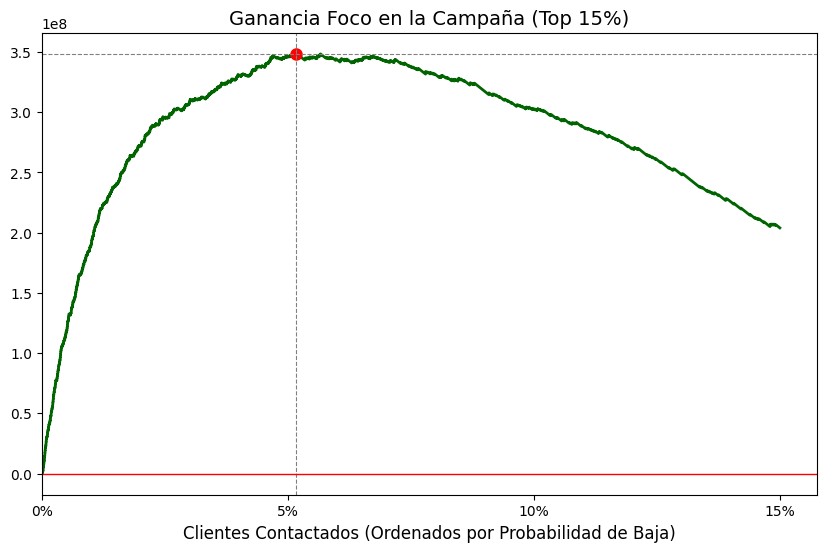

In [37]:
# Suponiendo que 'ganancia_cum' y 'y_val' son las variables de tu análisis:

plot_ganancia_acumulada_top_n(
    ganancia_cum, 
    y_val, 
    limite_porcentaje=0.15, 
    titulo="Ganancia Foco en la Campaña (Top 15%)"
)

In [39]:
# --- NUEVAS LÍNEAS A AGREGAR ---
# Encontrar el punto de corte óptimo y guardarlo
max_ganancia_idx = np.argmax(ganancia_cum)
# ESTA ES LA VARIABLE QUE DEBEMOS ALMACENAR GLOBALMENTE
n_envios_optimo = max_ganancia_idx + 1 
# -----------------------------

In [40]:
# Encontrar el punto de corte óptimo
#max_ganancia_idx = np.argmax(ganancia_cum)
#max_ganancia = ganancia_cum[max_ganancia_idx]
#n_envios_optimo = max_ganancia_idx + 1
#threshold_optimo = y_val_pred_prob[indices_ordenados[max_ganancia_idx]]

print(f"\n📊 RESULTADOS EN VALIDACIÓN:")
#print(f"  Ganancia máxima: ${max_ganancia:,.0f}")
#print(f"  N° de envíos óptimo: {n_envios_optimo:,}")
#print(f"  Threshold óptimo: {threshold_optimo:.6f}")
#print(f"  % de la base: {n_envios_optimo / len(y_val) * 100:.2f}%")

# Probar diferentes cantidades de envíos
#print("\n📈 GANANCIA POR CANTIDAD DE ENVÍOS:")
#for percentil in [0.025, 0.025, 0.05, 0.10]:
#    n = int(len(y_val) * percentil)
#    ganancia_n = ganancia_cum[n-1] if n > 0 else 0
#    print(f"  Top {percentil*100:.1f}% ({n:,} envíos): ${ganancia_n:,.0f}")


📊 RESULTADOS EN VALIDACIÓN:


In [41]:
# -------------------
# Entrenar modelo final con todos los datos
# -------------------

# Preparar datos completos
y_binaria = ((y_train == "BAJA+2") | (y_val == "BAJA+1")).astype(int)

# Crear pesos para todos los datos (usar los mismos que en validación)
w_all = y_binaria * 1.00002 + (1 - y_binaria) * 1.0

X_final = np.concatenate([X_train, X_val], axis=0)

# Crear dataset completo
full_data = lgb.Dataset(X_final,
                        label=y_binaria,
                        weight=w_all)

# Parámetros del modelo (los mismos que en validación)
params = {
    'objective': 'binary',
    # ¡IMPORTANTE! Cambiamos 'metric' a 'gan_eval' (el nombre devuelto por feval)
    # y agregamos 'auc' para monitoreo secundario, si se desea.
    'metric': ['gan_eval', 'auc'],
    'boosting_type': 'gbdt',
    # first_metric_only: True indica que el Early Stopping usará la primera métrica ('gan_eval')
    'first_metric_only': True, 
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': 50,
    'learning_rate': 0.05,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'seed': SEMILLAS[0],
    'verbose': -1
}

# Entrenar modelo final usando el mejor número de iteraciones
print("Entrenando modelo final con todos los datos...")
model_final = lgb.train(params,
                        full_data,
                        num_boost_round=model.best_iteration)

print(f"✅ Modelo entrenado con {model.best_iteration} iteraciones")

# -------------------
# Predicciones en Kaggle
# -------------------

# Preparar datos de Kaggle
X_kaggle = df_kaggle.drop("clase_ternaria", axis=1) 
X_kaggle_np = X_kaggle.to_numpy()

# Guardar número de cliente
clientes_kaggle = df_kaggle["numero_de_cliente"].to_list()

# Predicciones probabilísticas
y_pred_prob_kaggle = model_final.predict(X_kaggle_np)

# OPCIÓN 1: Usar el threshold óptimo de validación
#print(f"\n🎯 Usando threshold óptimo: {threshold_optimo:.6f}")
#y_pred_bin = (y_pred_prob_kaggle > threshold_optimo).astype(int)

# OPCIÓN 2 (RECOMENDADA): Usar el número óptimo de envíos
# Ordenar por probabilidad y tomar los top N
indices_top = np.argsort(-y_pred_prob_kaggle)[:n_envios_optimo]
y_pred_bin = np.zeros(len(y_pred_prob_kaggle), dtype=int)
y_pred_bin[indices_top] = 1
# OPCION 3
# Definir el umbral manual
#threshold_manual = 0.025 

# -----------------------------------------------------------
# OPCIÓN 1: Usar el threshold manual de 0.025
#print(f"\n🎯 Usando threshold manual: {threshold_manual:.6f}")

# Aplicar el umbral: 1 si la probabilidad es mayor a 0.025, 0 en caso contrario
#y_pred_bin = (y_pred_prob_kaggle > threshold_manual).astype(int)

# Crear DataFrame final para Kaggle
submission = pd.DataFrame({
    "numero_de_cliente": clientes_kaggle,
    "Predicted": y_pred_bin
})

# Guardar archivo CSV
submission.to_csv("predicciones_kaggle.csv", index=False)

print("\n✅ Archivo 'predicciones_kaggle.csv' generado con éxito")
print(f"Total predicciones: {len(submission):,}")
print(f"Predicciones positivas: {y_pred_bin.sum():,}")
print(f"% del total: {y_pred_bin.sum() / len(submission) * 100:.2f}%")
submission.head()

Entrenando modelo final con todos los datos...
✅ Modelo entrenado con 98 iteraciones

✅ Archivo 'predicciones_kaggle.csv' generado con éxito
Total predicciones: 164,313
Predicciones positivas: 8,430
% del total: 5.13%


,numero_de_cliente,Predicted
0,249320580,0
1,249368642,0
2,249483501,0
3,249493416,0
4,249494219,0


In [42]:
#shape de predicciones_kaggle
print(submission.shape)

#tienen titulo?
print(submission.columns)

(164313, 2)
Index(['numero_de_cliente', 'Predicted'], dtype='object')


In [23]:
# Suponiendo que df_predicciones es el DataFrame listo para exportar
total_filas = len(submission)
total_clientes_unicos = submission['numero_de_cliente'].nunique()

print(f"Total de filas en el archivo: {total_filas}")
print(f"Total de clientes únicos: {total_clientes_unicos}")

# Si hay duplicados, esto será True
hay_duplicados = total_filas != total_clientes_unicos

if hay_duplicados:
    print("\n🚨 ¡ERROR! El número de filas NO coincide con el número de clientes únicos.")
    print("Debes eliminar los duplicados de la columna 'numero_de_cliente' antes de exportar.")
else:
    print("\n✅ Los IDs son únicos. Revisa la estructura del CSV exportado.")

Total de filas en el archivo: 164313
Total de clientes únicos: 164050

🚨 ¡ERROR! El número de filas NO coincide con el número de clientes únicos.
Debes eliminar los duplicados de la columna 'numero_de_cliente' antes de exportar.
